In [1]:
from importlib import reload
import torch
import torch.nn.functional as F
import torch_geometric as pytg
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from sklearn.metrics import precision_score, recall_score

import data
reload(data)
from data import AmlsimDataset

import modules
reload(modules)
from modules import GCN, GAT

In [2]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
# Load data
traindata = AmlsimDataset(node_file='data/simulation2/swedbank/train/nodes.csv', edge_file='data/simulation2/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
testdata = AmlsimDataset(node_file='data/simulation2/swedbank/test/nodes.csv', edge_file='data/simulation2/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
traindata = traindata.to(device)
testdata = testdata.to(device)

In [4]:
# Normalize data
mean = traindata.x.mean(dim=0, keepdim=True)
std = traindata.x.std(dim=0, keepdim=True)
traindata.x = (traindata.x - mean) / std
testdata.x = (testdata.x - mean) / std

In [5]:
# Instantiate model
in_channels = 10
hidden_channels = 10
out_channels = 2
num_heads = 3
dropout = 0.3
model = GAT(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_heads = num_heads, dropout=dropout)
model.to(device)

GAT(
  (conv1): GATConv(10, 10, heads=3)
  (conv2): GATConv(30, 10, heads=3)
  (conv3): GATConv(30, 2, heads=1)
)

In [6]:
# Lite testning!
out, aw1, aw2, aw3 = model(traindata.x, traindata.edge_index)
print(out[0])

def get_attention_weights(attention_output):
    edge_index, attention_weights = attention_output
    edge_index, attention_weights = pytg.utils.remove_self_loops(edge_index, attention_weights)
    return edge_index, attention_weights

edge_index, attention_weights = get_attention_weights(aw3)
print(edge_index.shape)
print(attention_weights.shape)

print(edge_index[:,0])
print(attention_weights[0,:])


tensor([-0.0623, -0.1714], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([2, 1194])
torch.Size([1194, 1])
tensor([  0, 858], device='cuda:0')
tensor([0.], device='cuda:0', grad_fn=<SliceBackward0>)


In [7]:
# optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
# loss function
weight = torch.tensor([1, 5.5], dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight = weight)

In [9]:
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out,_,_,_ = model(traindata.x, traindata.edge_index)
    loss = criterion(out, traindata.y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            out,_,_,_ = model(testdata.x, testdata.edge_index)
            loss = criterion(out, testdata.y)
            precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

epoch: 10, loss: 0.7165, precision: 0.3333, recall: 0.3735
epoch: 20, loss: 0.7058, precision: 0.4716, recall: 0.5000
epoch: 30, loss: 0.6809, precision: 0.4918, recall: 0.5422
epoch: 40, loss: 0.6501, precision: 0.4847, recall: 0.5723
epoch: 50, loss: 0.6223, precision: 0.4498, recall: 0.6205
epoch: 60, loss: 0.6018, precision: 0.4036, recall: 0.6807
epoch: 70, loss: 0.5889, precision: 0.3760, recall: 0.8494
epoch: 80, loss: 0.5799, precision: 0.3268, recall: 0.8976
epoch: 90, loss: 0.5746, precision: 0.3004, recall: 0.9699
epoch: 100, loss: 0.5716, precision: 0.2985, recall: 0.9819
epoch: 110, loss: 0.5679, precision: 0.2972, recall: 0.9759
epoch: 120, loss: 0.5673, precision: 0.3207, recall: 0.9157
epoch: 130, loss: 0.5660, precision: 0.3254, recall: 0.9036
epoch: 140, loss: 0.5653, precision: 0.3106, recall: 0.9337
epoch: 150, loss: 0.5636, precision: 0.3061, recall: 0.9699
epoch: 160, loss: 0.5630, precision: 0.2987, recall: 0.9880
epoch: 170, loss: 0.5627, precision: 0.2978, reca

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out,_,_,_ = model(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

label_0_count = np.count_nonzero(y_true == 0)
label_1_count = np.count_nonzero(y_true == 1)
print(f"Number ground truth labels equal to 0: {label_0_count}")
print(f"Number ground truth labels equal to 1: {label_1_count}")

print(f"recall = {cm[1, 1] / label_1_count}")
print(f"False positive rate = {cm[0, 1] / label_0_count}")

[[  2 398]
 [  0 166]]
Number ground truth labels equal to 0: 400
Number ground truth labels equal to 1: 166
recall = 1.0
False positive rate = 0.995


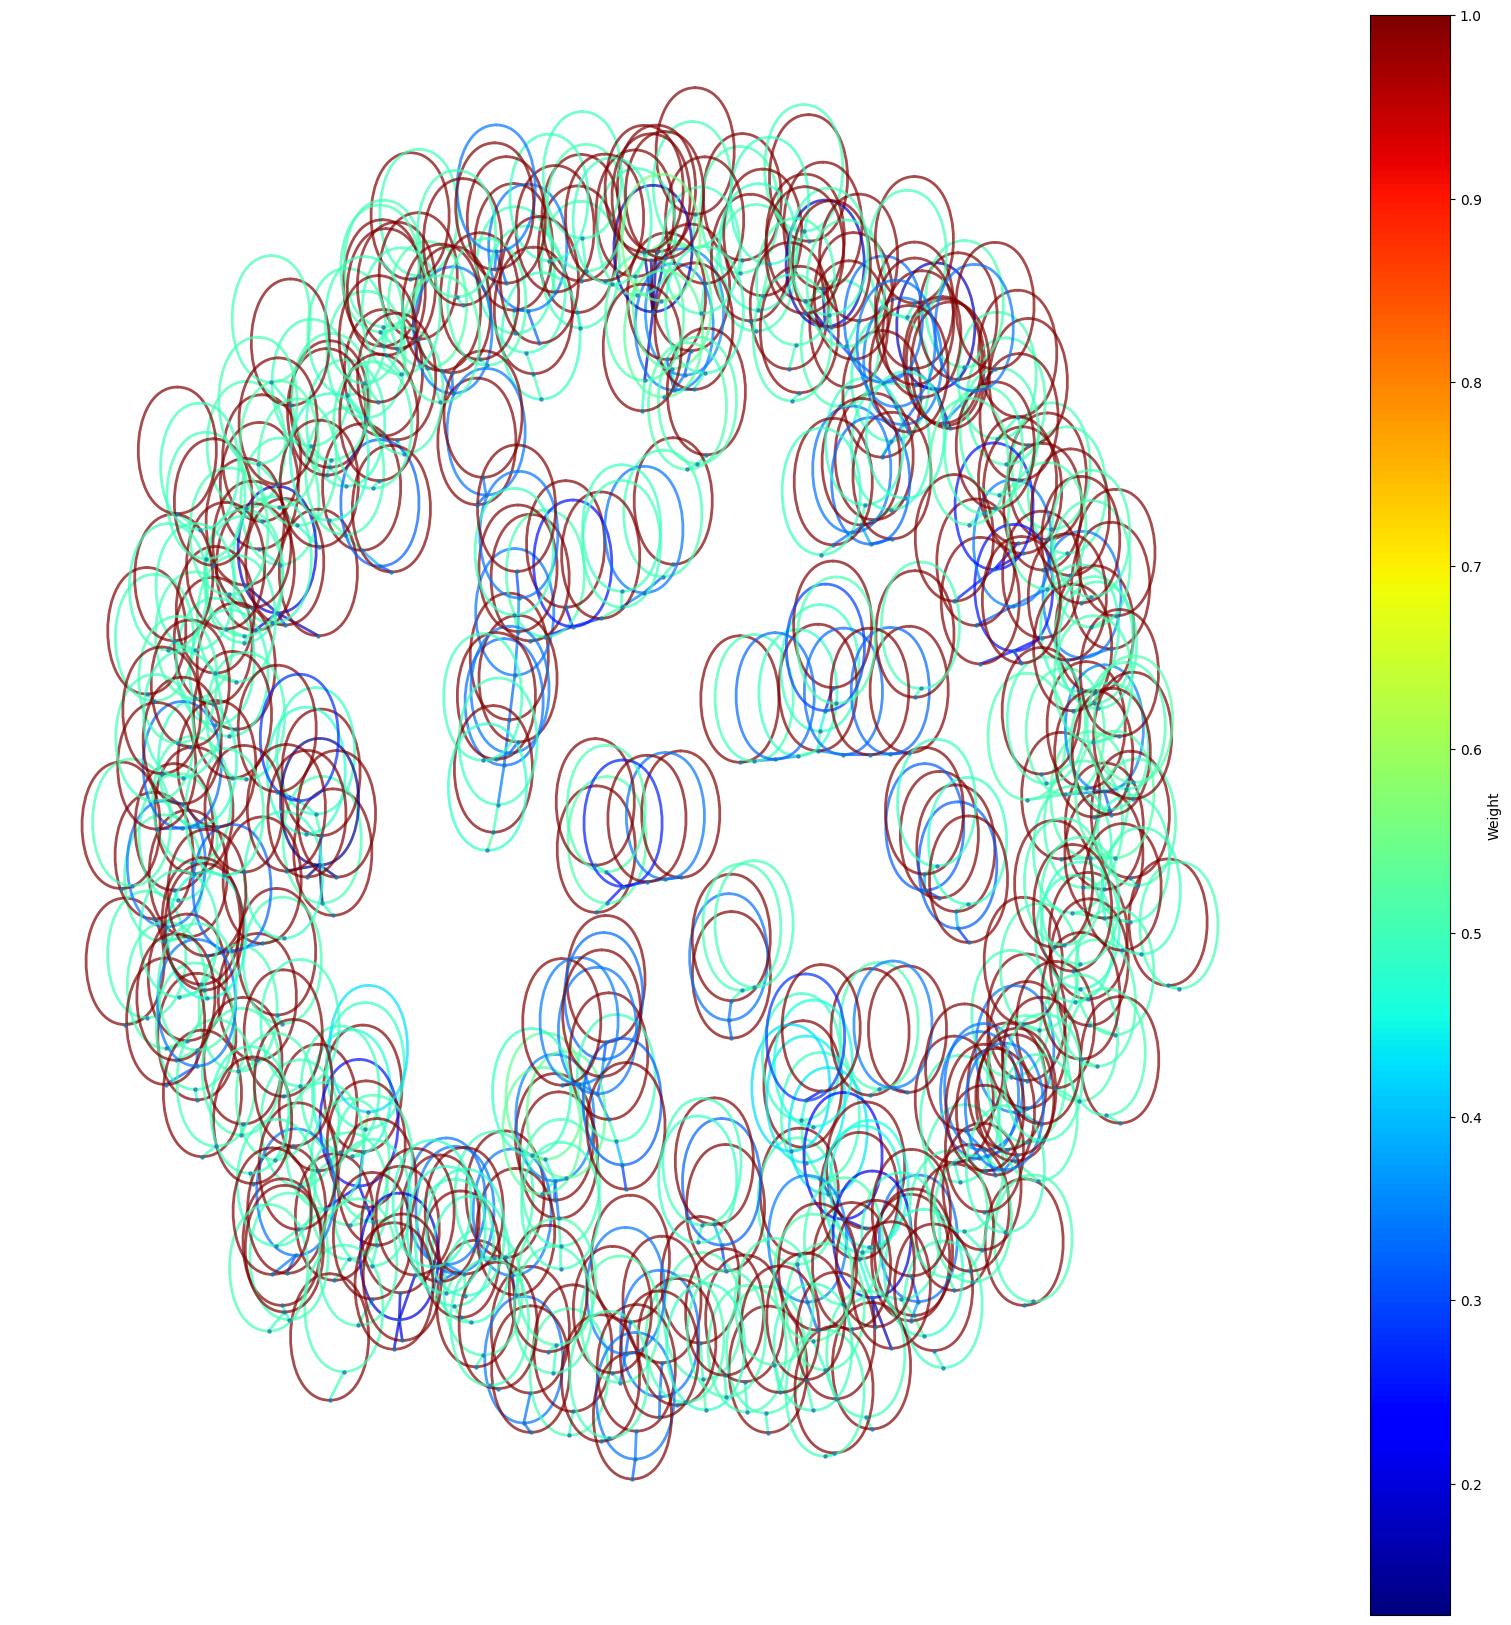

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have your weights in a torch tensor `weights` and edge indices in `edge_indices`
# Create a graph

model.eval()
with torch.no_grad():
    out,aw1,aw2,aw3 = model(testdata.x, testdata.edge_index)

edge_indices, attention_weights = get_attention_weights(aw3)
edge_indices = aw3[0]
attention_weights = aw3[1]

G = nx.Graph()

# Add edges with weights
for i in range(edge_indices.size(1)):
    src, dst = edge_indices[:, i]
    weight = attention_weights[i].item()  # Assuming weights is a torch tensor
    G.add_edge(src.item(), dst.item(), weight=weight)

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Create a colormap based on edge weights
cmap = plt.cm.jet

# Increase the size of the plot
plt.figure(figsize=(16, 16))

# Plot the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=False, edge_color=edge_weights, edge_cmap=cmap, width=2, node_size=5, alpha=0.7)

# Add a color bar to show the mapping of weights to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
plt.colorbar(sm, label='Weight', ax = plt.gca())

plt.show()


In [31]:
print(type(aw3))
print(len(aw3))


2


In [29]:
node_to_inspect = 1
edges = []



for i in range(edge_indices.size(1)):
    column = edge_indices[:, i]
    if column[0] == node_to_inspect or column[1] == node_to_inspect:
        edges.append(i)
        print(f"Edge {i} connects to node {node_to_inspect}")


print(f'{edge_indices[:,1]}, {edge_indices[:,2]}, {edge_indices[:,388]}')
print(f'{attention_weights[1]}, {attention_weights[2]}, {attention_weights[388]}')

node_to_inspect = 532
edges = []

for i in range(edge_indices.size(1)):
    column = edge_indices[:, i]
    if column[0] == node_to_inspect or column[1] == node_to_inspect:
        edges.append(i)
        print(f"Edge {i} connects to node {node_to_inspect}")

print(f'{edge_indices[:,1]}, {edge_indices[:,244]}, {edge_indices[:,919]}')
print(f'{attention_weights[1]}, {attention_weights[244]}, {attention_weights[919]}')
print(f'sum of attention weights for node 532 = {attention_weights[1].item() + attention_weights[244].item() + attention_weights[919].item()}')

print(attention_weights.max())
print(attention_weights.min())


(tensor([[  0,   1,   1,  ..., 563, 564, 565],
        [529, 532, 551,  ..., 563, 564, 565]], device='cuda:0'), tensor([[0.2858],
        [0.3248],
        [0.3265],
        [0.1542],
        [0.4978],
        [0.4904],
        [0.4971],
        [0.5123],
        [0.5281],
        [0.2897],
        [0.4963],
        [0.4960],
        [0.4902],
        [0.4951],
        [0.4943],
        [0.4935],
        [0.4948],
        [0.2991],
        [0.4813],
        [0.3740],
        [0.3283],
        [0.4949],
        [0.4987],
        [0.4972],
        [0.1800],
        [0.5025],
        [0.3479],
        [0.2236],
        [0.3289],
        [0.3426],
        [0.3164],
        [0.2998],
        [0.5123],
        [0.5108],
        [0.3638],
        [0.2605],
        [0.3444],
        [0.2966],
        [0.4949],
        [0.4905],
        [0.4988],
        [0.4946],
        [0.3359],
        [0.4968],
        [0.4962],
        [0.3309],
        [0.5036],
        [0.5047],
        [0.4958],
      

Edge 1 connects to node 1
Edge 2 connects to node 1
[1, 2]
[[0.32483542]
 [0.32653293]]


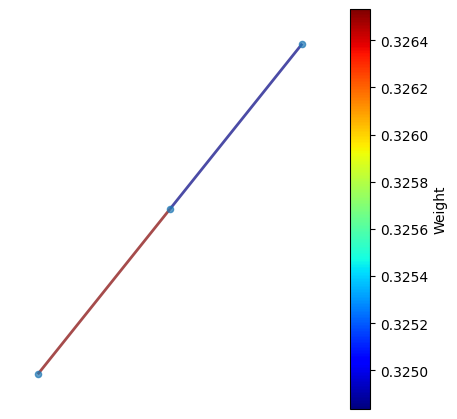

In [12]:
node_to_inspect = 1
edges = []

for i in range(edge_indices.size(1)):
    column = edge_indices[:, i]
    if column[0] == node_to_inspect or column[1] == node_to_inspect:
        edges.append(i)
        print(f"Edge {i} connects to node {node_to_inspect}")

print(edges)
print(attention_weights[edges].to('cpu').numpy())

# Create a graph
G = nx.Graph()

# Add edges with weights
for i in edges:
    src, dst = edge_indices[:, i]
    weight = attention_weights[i].item()
    G.add_edge(src.item(), dst.item(), weight=weight)

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Create a colormap based on edge weights
cmap = plt.cm.jet

# Increase the size of the plot
plt.figure(figsize=(4,4))

# Plot the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=False, edge_color=edge_weights, edge_cmap=cmap, width=2, node_size=20, alpha=0.7)

# Add a color bar to show the mapping of weights to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
plt.colorbar(sm, label='Weight', ax=plt.gca())

plt.show()

